In [1]:
import numpy as np
from scipy.sparse import csgraph
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [2]:
A = np.random.random((5,5))
np.fill_diagonal(A, 0)
A

array([[0.        , 0.03341832, 0.17211948, 0.87095617, 0.68485632],
       [0.71919553, 0.        , 0.9516198 , 0.15892631, 0.54143709],
       [0.94585285, 0.46284874, 0.        , 0.15662223, 0.72561016],
       [0.60233722, 0.18879201, 0.6644589 , 0.        , 0.47258751],
       [0.35890866, 0.03464987, 0.89160787, 0.57572553, 0.        ]])

In [3]:
L = csgraph.laplacian(A, normed=True)
L

array([[ 1.        , -0.02430718, -0.06487937, -0.4048492 , -0.27140477],
       [-0.5231146 ,  1.        , -0.68522522, -0.14111918, -0.40988239],
       [-0.35653339, -0.33327977,  1.        , -0.07207263, -0.28466979],
       [-0.27998624, -0.16763852, -0.30576313,  1.        , -0.2286339 ],
       [-0.14223352, -0.02623088, -0.34979365, -0.27853121,  1.        ]])

#### Remark on the Embedding Propagation paper

In the paper they calculate the Laplacian by:
$$
D^{-1/2}AD^{-1/2}.
$$

Given the wikipedia article and the output of the function above I would say that this is not entirely correct.
The function outputs:
$$
I - D^{-1/2}AD^{-1/2}.
$$

This then is inline with what the paper call the propagator matrix P which is equal to:
$$
P = (I - \alpha D^{-1/2}AD^{-1/2})^{-1}
$$

I would say that this is slightly different to calculating just Lsym and using that.

In [4]:
#Calculate the propagator matrix.
alpha = 0.1
P = alpha*L
np.fill_diagonal(P, 1)
P = np.linalg.inv(P)
P

array([[1.00207194, 0.0035062 , 0.00900838, 0.04147828, 0.0285452 ],
       [0.05615476, 1.00293341, 0.07122094, 0.01819555, 0.045076  ],
       [0.03829118, 0.03380508, 1.00396731, 0.01013316, 0.03123645],
       [0.03054812, 0.01804465, 0.0329749 , 1.00243725, 0.02542652],
       [0.01659038, 0.00436573, 0.03635154, 0.02891315, 1.00232509]])

### Example

In [5]:
data_set = []
num_centers = 5
num_points = 4
alpha = 1

c_centers = np.random.normal(loc=0, scale=5, size=(num_centers,2))

for c in c_centers:
    data_set += [c]
    a = 0
    for i in range(num_points):
        r = (np.random.normal(scale=0.3)+alpha)*np.array([np.cos(a), np.sin(a)])
        data_set += [c+r]
        a += (2*np.pi)/num_points
data_set = np.array(data_set)    

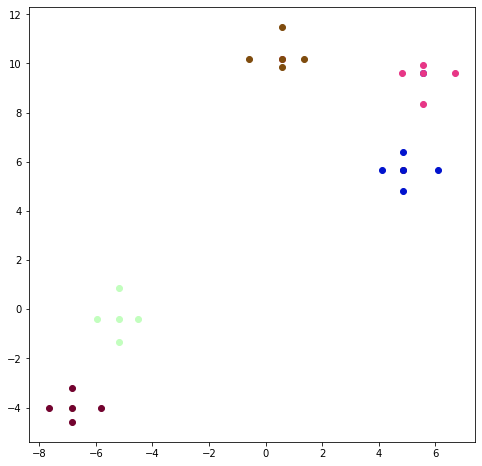

In [6]:
fig = plt.figure(figsize=(8,8))
colors = []
for i, c in enumerate(c_centers):
    rgb = (np.random.random(), np.random.random(), np.random.random())
    colors += [rgb]
    plt.scatter(data_set[i*(num_points+1):(i+1)*(num_points+1)+1,0], data_set[i*(num_points+1):(i+1)*(num_points+1)+1,1], c=[rgb])


In [15]:
#Create distance matrix
d = np.zeros((len(data_set),len(data_set)))
for i in range(len(data_set)):
    for j in range(len(data_set)):
        d[i,j] = np.linalg.norm(data_set[i]-data_set[j])

A = np.exp(-d/np.var(d))
L = csgraph.laplacian(A, normed=True)
p_alpha = 0.5
P = p_alpha*L
np.fill_diagonal(P, 1)
P = np.linalg.inv(P)

'''
transformed_data_set  = np.zeros((data_set.shape[0], data_set.shape[1]))
for i in range(len(transformed_data_set)):
    transformed_data_set[i] = np.sum(np.array([P[i,j]*data_set[j,:] for j in range(len(data_set))]), axis=0)
'''
transformed_data_set = np.matmul(P, data_set)

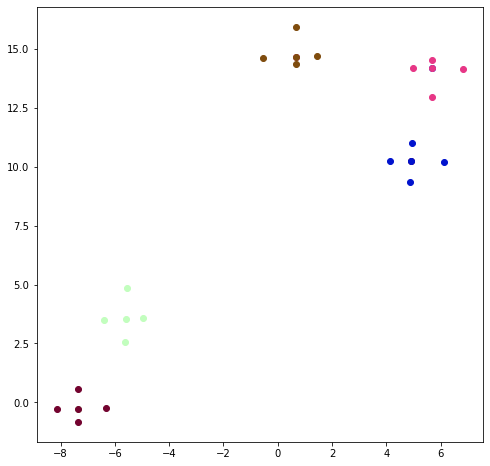

In [8]:
fig = plt.figure(figsize=(8,8))
for i, c in enumerate(c_centers):
    plt.scatter(transformed_data_set[i*(num_points+1):(i+1)*(num_points+1)+1,0], transformed_data_set[i*(num_points+1):(i+1)*(num_points+1)+1,1], c=[colors[i]])

In [9]:
def get_similarity_matrix(x, rbf_scale):
    b, c = x.size()
    sq_dist = ((x.view(b, 1, c) - x.view(1, b, c))**2).sum(-1) / np.sqrt(c)
    mask = sq_dist != 0
    sq_dist = sq_dist / sq_dist[mask].std()
    weights = torch.exp(-sq_dist * rbf_scale)
    mask = torch.eye(weights.size(1), dtype=torch.bool, device=weights.device)
    weights = weights * (~mask).float()
    return weights

In [10]:
def global_consistency(weights, alpha=1, norm_prop=False):
    """Implements D. Zhou et al. "Learning with local and global consistency". (Same as in TPN paper but without bug)
    Args:
        weights: Tensor of shape (n, n). Expected to be exp( -d^2/s^2 ), where d is the euclidean distance and
            s the scale parameter.
        labels: Tensor of shape (n, n_classes)
        alpha: Scaler, acts as a smoothing factor
    Returns:
        Tensor of shape (n, n_classes) representing the logits of each classes
    """
    n = weights.shape[1]
    identity = torch.eye(n, dtype=weights.dtype)
    isqrt_diag = 1. / torch.sqrt(0.0001 + torch.sum(weights, dim=-1))
    # checknan(laplacian=isqrt_diag)
    S = isqrt_diag[None, :] * weights * isqrt_diag[:, None]
    # checknan(normalizedlaplacian=S)
    propagator = identity - alpha * S
    propagator = torch.inverse(propagator[None, ...])[0]
    # checknan(propagator=propagator)
    if norm_prop:
        propagator = F.normalize(propagator, p=1, dim=-1)
    return propagator

In [11]:
r = global_consistency(get_similarity_matrix(torch.tensor(data_set), 1), alpha=0.5)
prop = r.numpy()

'''
t_data_set  = np.zeros((data_set.shape[0], data_set.shape[1]))
for i in range(len(t_data_set)):
    t_data_set[i] = np.sum(np.array([prop[i,j]*data_set[j,:] for j in range(len(data_set))]), axis=0)
'''
t_data_set = np.matmul(prop, data_set)

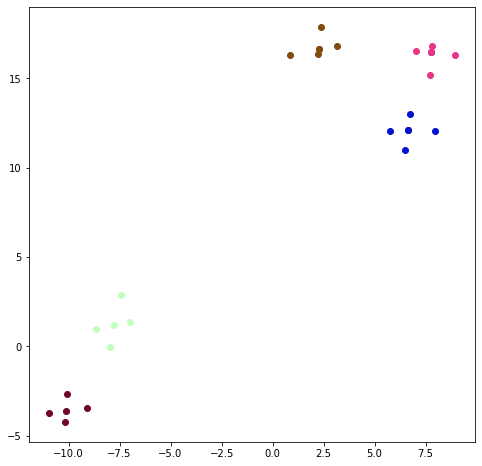

In [12]:
fig = plt.figure(figsize=(8,8))
for i, c in enumerate(c_centers):
    plt.scatter(t_data_set[i*(num_points+1):(i+1)*(num_points+1)+1,0], t_data_set[i*(num_points+1):(i+1)*(num_points+1)+1,1], c=[colors[i]])

In [13]:
transformed_data_set - t_data_set

array([[ 2.1638289 ,  2.34104056],
       [ 2.04775139,  2.18196134],
       [ 1.88207499,  1.98252117],
       [ 2.28474519,  2.52112688],
       [ 2.34741279,  2.58414368],
       [ 2.78863531,  3.32544635],
       [ 2.73549915,  3.20788336],
       [ 2.74649026,  3.22276758],
       [ 2.80787812,  3.40928959],
       [ 2.80733358,  3.3877328 ],
       [-1.70803803, -1.87191898],
       [-1.84153398, -1.85827195],
       [-1.80656327, -2.01828445],
       [-1.6028391 , -1.84750189],
       [-1.57785649, -1.67113571],
       [-2.08787348, -2.27412676],
       [-2.12601762, -2.17164629],
       [-2.09468716, -2.2721526 ],
       [-2.0503805 , -2.31469306],
       [-2.04322633, -2.24069023],
       [-1.59083668, -1.96816518],
       [-1.70842641, -2.103934  ],
       [-1.66842106, -1.94086767],
       [-1.389852  , -1.72158799],
       [-1.56504125, -1.96300995]])